# Taming systematic uncertainties

In this notebook, we will demonstrate how one can model their systematic uncertainties by adding nuisance parameters to their MLE. Things are not implemented here efficiently, but instructively. That means we typing out a lot of equations without taking shortcuts. This should make it easier to follow along, but also makes it in some cases computationally slow.

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
import scipy.integrate
import numdifftools
from tqdm import tqdm
from uncertainties import ufloat
from copy import deepcopy

import plothist

np.random.seed(0)

In [3]:
DIRNAME = "data"

In [4]:
try:
    os.mkdir(DIRNAME)
except FileExistsError:
    pass

In [5]:
np.seterr(all='ignore');  # For a nicer saved notebook 

We use an exponential distribution $\mathcal{E}(2.0)$ as background and a normal distribution $\mathcal{N}(3.0, 0.5)$ as signal distribution to generate our "MC".

In [6]:
distributions = [
        { "type": np.random.exponential, "kwargs": { "scale": 2.0 }},
        { "type": np.random.normal,  "kwargs": { "loc": 3.0, "scale": 0.5 }},
    ]

def generate_distribution(N, distributions, component=None):
    coefficients = np.array([0.88, 0.12])
    coefficients /= coefficients.sum()

    num_distr = len(distributions)

    data = np.zeros((N, num_distr))

    for idx, distr in enumerate(distributions):
        data[:, idx] = distr["type"](size=(N,), **distr["kwargs"])
    random_idx = np.random.choice(np.arange(num_distr), size=(N,), p=coefficients)

    if component is None:
        return data[np.arange(N), random_idx]
    else:
        return data[np.arange(N), component]

In [7]:
n_data = 10000
n_bkg = 900000
n_sig = 100000

data = generate_distribution(n_data, distributions, None)
bkg_mc = generate_distribution(n_bkg, distributions, 0)
sig_mc = generate_distribution(n_sig, distributions, 1)

We are working with binned data, so let us bin the data!

In [8]:
x_range = (0, 6)
bins=20
template_data, template_data_boundaries = np.histogram(data, bins=bins, range=x_range)
template_bkg, template_bkg_boundaries = np.histogram(bkg_mc, bins=bins, range=x_range, 
                                                     weights=np.ones(len(bkg_mc))/100)
template_sig, template_sig_boundaries = np.histogram(sig_mc, bins=bins, range=x_range, 
                                                     weights=np.ones(len(sig_mc))/100)

In [9]:
nu_bkg_expected = sum(template_bkg)
nu_sig_expected = sum(template_sig)

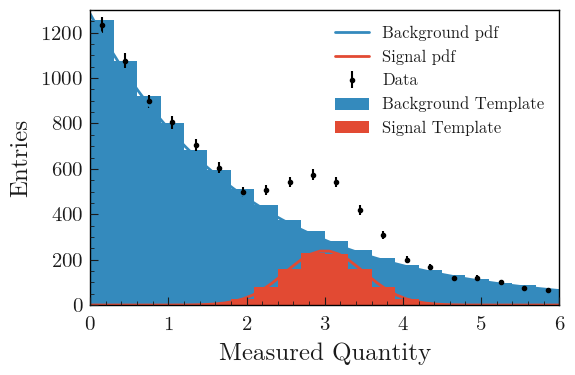

In [10]:
plt.errorbar(
    template_data_boundaries[:-1] + (template_data_boundaries[1] - template_data_boundaries[0])/2,
    template_data,
    yerr=np.sqrt(template_data),
    label="Data", ls='', marker='.', color='black'
)

plt.bar(
    template_bkg_boundaries[:-1] + (template_bkg_boundaries[1] - template_bkg_boundaries[0])/2,
    template_bkg,
    width=(template_bkg_boundaries[1] - template_bkg_boundaries[0]),
    label='Background Template', 
)

plt.plot(np.linspace(0, 6), 
         sum(template_bkg) * ((max(x_range) - min(x_range)) / bins) * scipy.stats.expon.pdf(np.linspace(0, 6), scale=2), 
         label='Background pdf', lw=2)

plt.bar(
    template_sig_boundaries[:-1] + (template_sig_boundaries[1] - template_sig_boundaries[0])/2,
    template_sig, 
    width=(template_sig_boundaries[1] - template_sig_boundaries[0]),
    label='Signal Template', 
)

plt.plot(np.linspace(0, 6), 
         sum(template_sig) * ((max(x_range) - min(x_range)) / bins) * scipy.stats.norm.pdf(np.linspace(0, 6), loc=3, scale=0.5), 
         label='Signal pdf', lw=2)


plt.xlabel("Measured Quantity")
plt.ylabel("Entries")
plt.legend()
plt.ylim(0,1300)
plt.xlim(0,6)
plt.tight_layout()

plt.savefig(os.path.join(DIRNAME,"pdf-to-template.png"), transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(DIRNAME,"pdf-to-template.pdf"))
plt.show()
plt.close()

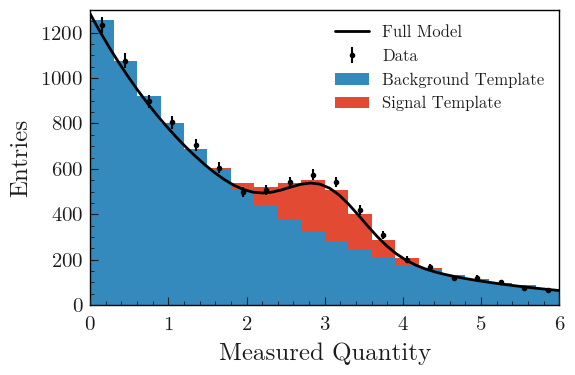

In [11]:
plt.errorbar(
    template_data_boundaries[:-1] + (template_data_boundaries[1] - template_data_boundaries[0])/2,
    template_data,
    yerr=np.sqrt(template_data),
    label="Data", ls='', marker='.', color='black'
)

plt.bar(
    template_bkg_boundaries[:-1] + (template_bkg_boundaries[1] - template_bkg_boundaries[0])/2,
    template_bkg,
    width=(template_bkg_boundaries[1] - template_bkg_boundaries[0]),
    label='Background Template', 
)

plt.bar(
    template_sig_boundaries[:-1] + (template_sig_boundaries[1] - template_sig_boundaries[0])/2,
    template_sig, bottom=template_bkg,
    width=(template_sig_boundaries[1] - template_sig_boundaries[0]),
    label='Signal Template', 
)

plt.plot(np.linspace(0, 6), 
         [sum(template_bkg) * ((max(x_range) - min(x_range)) / bins) * scipy.stats.expon.pdf(x, scale=2) + sum(template_sig) * ((max(x_range) - min(x_range)) / bins) * scipy.stats.norm.pdf(x, loc=3, scale=0.5)
          for x in np.linspace(0, 6)],
         label='Full Model', lw=2, color='black')

plt.xlabel("Measured Quantity")
plt.ylabel("Entries")
plt.legend()
plt.ylim(0,1300)
plt.xlim(0,6)
plt.tight_layout()

plt.savefig(os.path.join(DIRNAME,"pdf-to-template2.png"), transparent=True, bbox_inches='tight')
plt.savefig(os.path.join(DIRNAME,"pdf-to-template2.pdf"))
plt.show()
plt.close()

In [12]:
def sanitize_uncertainty(x):
    x[x==0] = 1e-7
    return x

def correlation_from_covariance(x):
    return x / np.outer(np.sqrt(x.diagonal()), np.sqrt(x.diagonal()))

template_bkg_stat, _ = np.histogram(bkg_mc, bins=bins, range=x_range,
                               weights=(np.ones(len(bkg_mc))/100)**2)
template_sig_stat, _ = np.histogram(sig_mc, bins=bins, range=x_range, 
                               weights=(np.ones(len(sig_mc))/100)**2)

template_bkg_stat = sanitize_uncertainty(template_bkg_stat)
template_sig_stat = sanitize_uncertainty(template_sig_stat)

bkg_stat_covariance = np.diag(template_bkg_stat**2)
sig_stat_covariance = np.diag(template_sig_stat**2)

def get_relative_error_and_inv_correlation(template, covariance):
    uncertainty_per_bin = np.diag(covariance)**0.5
    relative_error = np.nan_to_num(uncertainty_per_bin / template, posinf=1e-7)
    correlation = correlation_from_covariance(covariance)
    return relative_error, np.linalg.inv(correlation)

In [13]:
# Calculate the inverse of the correlations once, and reuse that later, instead of doing this in each step of the Likelihood minimization.
# (It is computational very expensive)
template_bkg_relative_errors, inv_bkg_correlation = get_relative_error_and_inv_correlation(
    template_bkg, bkg_stat_covariance)
template_sig_relative_errors, inv_sig_correlation = get_relative_error_and_inv_correlation(
    template_sig, sig_stat_covariance)

In [14]:
def plot_template(template_data, template_bkg, template_sig, fit_result=None, debug=False, figname=None):

    plt.errorbar(
        template_data_boundaries[:-1] + (template_data_boundaries[1] - template_data_boundaries[0])/2,
        template_data,
        yerr=np.sqrt(template_data),
        label="Data", ls='', marker='.', color='black'
    )
    
    copy_bkg_template = deepcopy(template_bkg)
    copy_sig_template = deepcopy(template_sig)
    if fit_result is not None:
        
        nBins = 20
        nParamaterOfInterest = 2
        nParameterOfNuisance = 2 * nBins
        par_interest = fit_result.x[:nParamaterOfInterest]
        par_nuisance = fit_result.x[nParamaterOfInterest:nParamaterOfInterest+nParameterOfNuisance]
    
        copy_bkg_template *= par_interest[0] / sum(copy_bkg_template)
        copy_sig_template *= par_interest[1] / sum(copy_sig_template)
        if len(par_nuisance) == 0:
            par_nuisance = np.zeros(nParameterOfNuisance)
        copy_bkg_template *= (1 + par_nuisance[:bins] * template_bkg_relative_errors)
        copy_sig_template *= (1 + par_nuisance[bins:] * template_sig_relative_errors)
    
    plt.bar(
        template_bkg_boundaries[:-1] + (template_bkg_boundaries[1] - template_bkg_boundaries[0])/2,
        copy_bkg_template,
        width=(template_bkg_boundaries[1] - template_bkg_boundaries[0]),
        label='Background'
    )

    plt.bar(
        template_sig_boundaries[:-1] + (template_sig_boundaries[1] - template_sig_boundaries[0])/2,
        copy_sig_template, bottom=copy_bkg_template,
        width=(template_sig_boundaries[1] - template_sig_boundaries[0]),
        label="Signal",
    )
        
    plt.xlabel("Measured Quantity")
    plt.ylabel("Entries")
    plt.legend()
    plt.ylim(0,1300)
    plt.xlim(0,6)
    plt.tight_layout()
    if figname is not None:
        plt.savefig(os.path.join(DIRNAME, figname + ".png"), transparent=True, bbox_inches='tight')
        plt.savefig(os.path.join(DIRNAME, figname + ".pdf"))
    plt.show()
    plt.close()
    
    if debug:
        print(copy_bkg_template)
        print(copy_sig_template)

# Define datasets

Asimov Data: A dataset defined to be the same as the expectation

Data: The dataset from our (pseudo)experiment

In [15]:
asimov_data = template_sig + template_bkg
template_asimov = np.round(asimov_data).astype(int)

sample = (template_data, template_bkg, template_sig)  # data
# sample = (asimov_data, template_bkg, template_sig)  # asimov_data

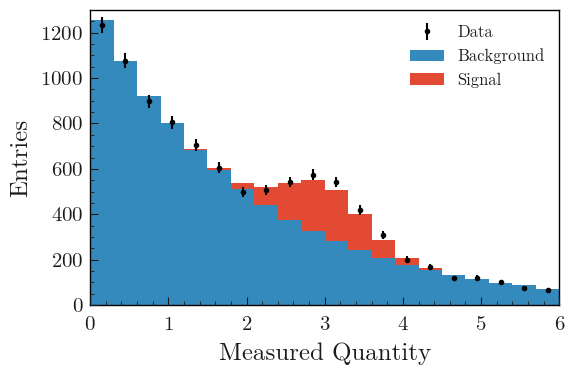

In [16]:
plot_template(*sample, figname='initial-problem')

# Exercise 1: Implement a likelihood function

We have our recorded data as black data points, and our signal and background templates in orange and blue. We want to extract the signal yields now. For this we deploy the method of Maximum Likelihood: $\mathcal{L} = \prod_i^{\text{nbins}} \mathcal{P}(n_i | \nu_i)$

We have $\mathcal{P}$ the Poisson distribution where $n_i$ is the number of measured data events in bin $i$, and $\nu_i$ the total number of expected events in bin $i$. 

$\nu_i$ = $\sum_k^\text{ntemplates} f_{ik} \eta_k$, 

where $\eta_k$ is the total number of events expected from template $k$ and $f_{ik}$ is the fraction of events expected in bin $i$ of template $k$.

For convenience (and computational stability) we use

$-2 \ln \mathcal{L} = -2 \sum_i^{\text{nbins}} \ln \mathcal{P}(n_i | \nu_i)$

So far, we did not include any (systematic) uncertainty into our fit model (the templates). Let us assume we know that our background template depends on a parameter $\lambda$ and this parameter has some model uncertainty. You got this from e.g. the performace group or it is an uncertainty in a theoretical model. Anyway, we need to include this uncertainty into our template!

The first one we are going to include is the uncertainty from limited MC statistics. This also helps us to avoid problems which arise when the covariance matrix is 100% correlated (like in the following). For that we simply assign the statistical uncertainty of the MC templates in each bin via $\sigma=\sum_i w_i^2$, where $w_i$ is the weight of the provided MC.

As this error originates from statistical uncertainty, the errors are uncorrelated in each bin. We build a covariance by $\mathcal{C} = diag(\sigma_i)$ where $\sigma_i$ is the uncertainty in each bin. We construct this for the signal an background template: $\mathcal{C}_\text{stat}^\text{sig}$, $\mathcal{C}_\text{stat}^\text{bkg}$, 

To include this uncertainty into the fit, we modify our likelihood and introduce nuisance parameters:

$\mathcal{L} = \prod_i^{\text{nbins}} \mathcal{P}(n_i | \nu_i(\theta)) \times \prod_k^\text{templates} \mathcal{N}(\theta_k|0, \mathcal{\Sigma}^k$)

The normal distribution is utilized to allow the nuisance parameter to vary within the uncertainty. $\Sigma_k$ is the total correlation matrix for any template. Currently this consists only of the statistical uncertainty for the signal and for the background template.
$\theta$ is the vector of nuisance parameters, $\theta_k$ the vector of nuisance parameters associated with template $k$.

As we can now vary individual bins within their uncertainty, the fraction of expected events in each bin is not constant, but varies!

$f_{ik} = \frac{\eta_{ik} (1 + \theta_{ik} \epsilon_{ik})}{\sum_k^\text{bins} \eta_{jk} (1 + \theta_{jk} \epsilon_{jk})}$.

Writing it like this ensures that pulling at a nuisance paramter does not change the normalization $\nu$. Indicies $i$: bin, $k$:template. $\epsilon$ is the relative uncertainty in of template $k$ in bin $i$. $\theta_{ik}$ is the nuisance parameter.

Now our likelihood depends on 2 parameters of interest: $\nu_\text{sig}$ and $\nu_\text{bkg}$ and a total of $(k=2) * (bins=30)$ nuisance parameter.

In [17]:
def likelihood(x, 
               bkg_errors, sig_errors, 
               inv_bkg_correlation, inv_sig_correlation, 
               *pars):
    """We pass arguments here, their meaning becomes clearer when unpacked. See the following lines."""
    
    data, bkg, sig = x  
    # data: Data histogram 
    # bkg: MC background histogram
    # sig: MC signal histogram

    nBins = 20
    nParamaterOfInterest = 2
    nParameterOfNuisance = 2 * nBins
    par_interest = pars[:nParamaterOfInterest]  # These are the yields, nu_sig and nu_bkg
    par_nuisance = pars[nParamaterOfInterest:nParamaterOfInterest+nParameterOfNuisance]  # These are the nuisance parameters for the shape uncertainties
    
    use_nuisance = True
    if len(par_nuisance) == 0: 
        par_nuisance = np.zeros(nParameterOfNuisance)
        use_nuisance = False
        
    par_nuisance_bkg = par_nuisance[:nBins]
    par_nuisance_sig = par_nuisance[nBins:]
    
    # Calculate the fraction of events we expect in each bin, either with or without nuisance parameters.
    # The signal and background errors are passed as an array to the function
    if use_nuisance:
        fractiong_bkg = bkg * (1 + par_nuisance_bkg * bkg_errors) / sum(bkg * (1 + par_nuisance_bkg * bkg_errors))
        fractions_sig = sig * (1 + par_nuisance_sig * sig_errors) / sum(sig * (1 + par_nuisance_sig * sig_errors))
    else:
        fractiong_bkg = bkg / sum(bkg)
        fractions_sig = sig / sum(sig)

    # Group it to a a list
    eta_k = [fractiong_bkg, fractions_sig]
        
    # Calculate the signal and background expectation in each bin
    nu_0_per_bin = par_interest[0] * eta_k[0]
    nu_1_per_bin = par_interest[1] * eta_k[1]
    nu_per_bin = [nu_0_per_bin, nu_1_per_bin]
    
    # We have now calculated /retrieved all inidividual parts we required to calculate the likelihood.
    # nu_per_bin is the expectation per bin
    # data is the observed data in each bin
    # inv_sig(bkg)_correlation was calculated once outside the function, but is passed to the function
    # Return the -2 ln likelihood, either with or without nuisance parameters.
    # (Although the function is called likelihood, return the -2ln likelihood)
    if use_nuisance:
        return -2 * sum(np.log(scipy.stats.poisson.pmf(data, sum(nu_per_bin)))) \
                + par_nuisance_bkg @ inv_bkg_correlation @ par_nuisance_bkg \
                + par_nuisance_sig @ inv_sig_correlation @ par_nuisance_sig
    else:
        return -2 * sum(np.log(scipy.stats.poisson.pmf(data, sum(nu_per_bin))))

In [18]:
def L(x, *pars):
    """Just a wrapper to make function calls easier (cache some arguments)."""
    return likelihood(x, 
                      template_bkg_relative_errors, template_sig_relative_errors, 
                      inv_bkg_correlation, inv_sig_correlation,
                      *pars)

In [19]:
# Call it once without nuisance parameters,
L(sample, nu_bkg_expected, nu_sig_expected)

168.67319336864531

In [20]:
# and once with nuisance parameters to be fitted
L(sample, nu_bkg_expected, nu_sig_expected, *np.zeros(40))

168.67319336864531

In [21]:
# note, if we chance the nuisance parameters, then the likelihood changes
L(sample, nu_bkg_expected, nu_sig_expected, *np.ones(40))

208.67319336864605

Next we run the fit on the data, to extract the parameters of interest, nu_bkg and nu_sig. To estimate the error, we can either use the Hesse approximation at the minimum of the Likelihood or perform a profile Likelihood scan.
The first one will automatically give us something which we can interpret at the covariance, the second one allows for asymetric errors.

In [22]:
fit_result = scipy.optimize.minimize(
    lambda x: L(sample, *x),
    x0=(nu_bkg_expected, nu_sig_expected),
    method="SLSQP"
)

hesse = numdifftools.Hessian(
    lambda x: L(sample, *x))(fit_result.x)

fit_result.covariance =  np.linalg.inv(hesse / 2)

In [23]:
def print_fit_result(fit_result):
    print("""
    nu(bkg) = {:.2f}
    nu(sig) = {:.2f}
    """.format(
        ufloat(fit_result.x[0], fit_result.covariance[0, 0]**0.5),
        ufloat(fit_result.x[1], fit_result.covariance[1, 1]**0.5)
    ))

print_fit_result(fit_result)


    nu(bkg) = 8435.71+/-104.35
    nu(sig) = 1127.43+/-59.83
    


In [24]:
fit_result_stat_only = deepcopy(fit_result)

In [25]:
def get_plot_range(fit_result, npar):
    return np.linspace(
        fit_result.x[npar] - 1.5 * fit_result.covariance[npar, npar]**0.5,
        fit_result.x[npar] + 1.5 * fit_result.covariance[npar, npar]**0.5
    )

In [26]:
def likelihood_scan(fit_result, ipar):

    fit_result_profile_scan = []
    for value in get_plot_range(fit_result, ipar):
        fit_result_profile = scipy.optimize.minimize(
            lambda x: L(sample, *x),
            x0=fit_result.x,
            method="SLSQP",
            constraints={'type': 'eq', 'fun': lambda x: x[ipar] - value}
        )
        fit_result_profile_scan.append(fit_result_profile)
    
    try: 
        fit_result_profile_scan_stat_only = []
        for value in get_plot_range(fit_result, ipar):
            fit_result_profile = scipy.optimize.minimize(
                lambda x: L(sample, *x, *fit_result.x[2:]),
                x0=fit_result.x[:2],
                method="SLSQP",
                constraints={'type': 'eq', 'fun': lambda x: x[ipar] - value}
            )
            fit_result_profile_scan_stat_only.append(fit_result_profile)
        return fit_result_profile_scan, fit_result_profile_scan_stat_only            
    except IndexError:
        return fit_result_profile_scan, None
                    
    


def plot_likelihood_scan(fit_result, fit_result_profile_scan, fit_result_profile_scan_stat_only, ipar, figname):
    plt.plot(
        get_plot_range(fit_result, ipar), 
        [fr.fun - fit_result.fun for fr in fit_result_profile_scan],
        label="Likelihood profile"
    )
    if fit_result_profile_scan_stat_only is not None:
        plt.plot(
            get_plot_range(fit_result, ipar), 
            [fr.fun - fit_result.fun for fr in fit_result_profile_scan_stat_only],
            label="stat. only", ls='dotted'
        )
    plt.errorbar(fit_result.x[ipar], 1, 
                 xerr=fit_result.covariance[ipar, ipar]**0.5,
                color='orange', marker='o', ls='-', lw=2,
                label="Gaussian approximation")

    subscript=1
    if ipar == 0:
        subscript=2
    
    plt.xlabel(r"$\eta_{"+f"_{subscript}"+"}$")
    if ipar==42:
        plt.xlabel(r"$\theta_{s}$")
    plt.ylabel(r"$-2\ln{(\mathcal{L/L}_\text{min})}$")
    plt.legend()
    plt.ylim(0,2.5)
    # plt.xlim(0,6)
    plt.tight_layout();
    if figname is not None:
        plt.savefig(os.path.join(DIRNAME, figname + ".png"), transparent=True, bbox_inches='tight')
        plt.savefig(os.path.join(DIRNAME, figname + ".pdf"))
    plt.show()        
    plt.close()

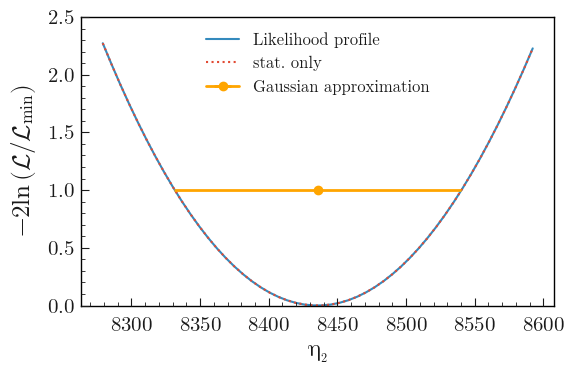

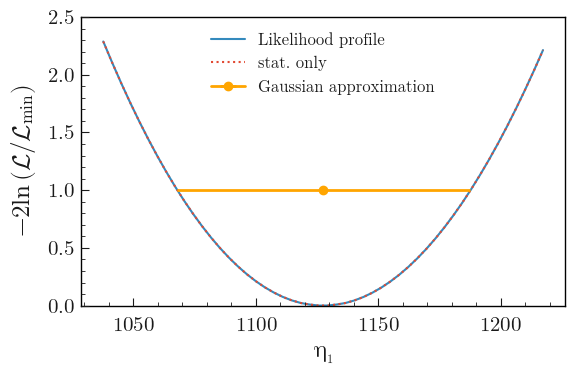

In [27]:
plot_likelihood_scan(fit_result, *likelihood_scan(fit_result, 0), 0, figname="profile-statonly-ipar0")
plot_likelihood_scan(fit_result, *likelihood_scan(fit_result, 1), 1, figname="profile-statonly-ipar1")

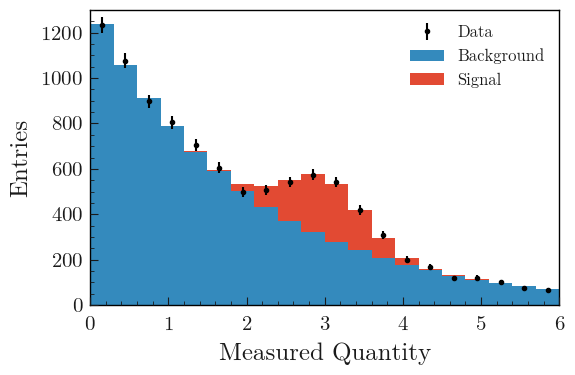

In [28]:
plot_template(*sample, fit_result=fit_result, debug=False, figname="template-statonly")

In [29]:
def generate_toy(nToys):
    toy_fit_results = []

    for i in tqdm(range(nToys)):
        template_toy = scipy.stats.poisson(template_asimov).rvs()
        toy_sample = (template_toy, template_bkg, template_sig)
        toy_result = scipy.optimize.minimize(
            lambda x: L(toy_sample, *x),
            x0=fit_result.x,
            method="SLSQP"
        )
        hesse = numdifftools.Hessian(lambda x: L(sample, *x))(toy_result.x)
        toy_result.covariance =  np.linalg.inv(hesse / 2)
        toy_fit_results.append(toy_result)
        
    return toy_fit_results
        
def plot_toy_fit_results(toy_fit_results, par, expected, figname=None):    

    plt.plot(
        np.linspace(-5, 5), 
        scipy.stats.norm.pdf(
            np.linspace(-5, 5)
        ),
        ls='solid', marker='', label='Expected')
    
    plt.hist([(r.x[par] - expected) / r.covariance[par, par]**0.5 for r in toy_fit_results],
             bins=20, range=(-5, 5), density=True, label="Toy Results")

    plt.legend()
    plt.xlabel("Pull")
    plt.ylabel("Entries")
    plt.tight_layout();
    if figname is not None:
        plt.savefig(os.path.join(DIRNAME, figname + ".png"), transparent=True)
        plt.savefig(os.path.join(DIRNAME, figname + ".pdf"))
    plt.show()        
    plt.close()
    print("Toy result: {:.2f}".format(ufloat(
        np.mean([(r.x[par] - expected) / r.covariance[par, par]**0.5 for r in toy_fit_results]),
        np.std([(r.x[par] - expected) / r.covariance[par, par]**0.5 for r in toy_fit_results])
    )))

In [30]:
# toy_fit_results = generate_toy(500)

In [31]:
# plot_toy_fit_results(toy_fit_results, 0, nu_bkg_expected, "toy-statonly-ipar0")
# plot_toy_fit_results(toy_fit_results, 1, nu_sig_expected, "toy-statonly-ipar1")

In [32]:
L(sample, *fit_result.x) - fit_result.fun

0.0

In [33]:
template_bkg_relative_errors, inv_bkg_correlation = get_relative_error_and_inv_correlation(
    template_bkg, bkg_stat_covariance)
template_sig_relative_errors, inv_sig_correlation = get_relative_error_and_inv_correlation(
    template_sig, sig_stat_covariance)

def L(x, *pars):
    return likelihood(x, 
                      template_bkg_relative_errors, template_sig_relative_errors, 
                      inv_bkg_correlation, inv_sig_correlation,
                      *pars)

In [34]:
fit_result = scipy.optimize.minimize(
    lambda x: L(sample, *x),
    x0=(nu_bkg_expected, nu_sig_expected, *np.zeros(40)),
    method="SLSQP"
)

In [35]:
hesse = numdifftools.Hessian(
    lambda x: L(sample, *x))(fit_result.x)

fit_result.covariance =  np.linalg.inv(hesse / 2)

In [36]:
print_fit_result(fit_result)


    nu(bkg) = 8434.66+/-104.79
    nu(sig) = 1128.25+/-60.63
    


In [37]:
fit_result_limited_mc_stat = deepcopy(fit_result)

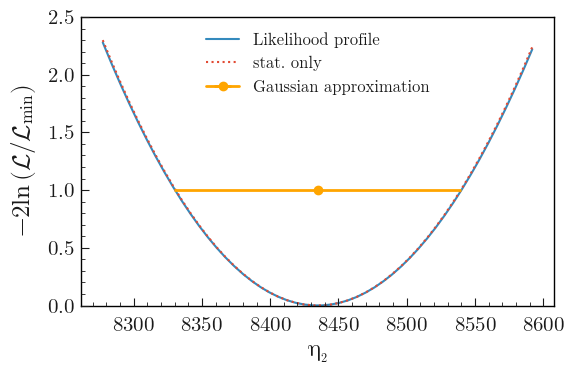

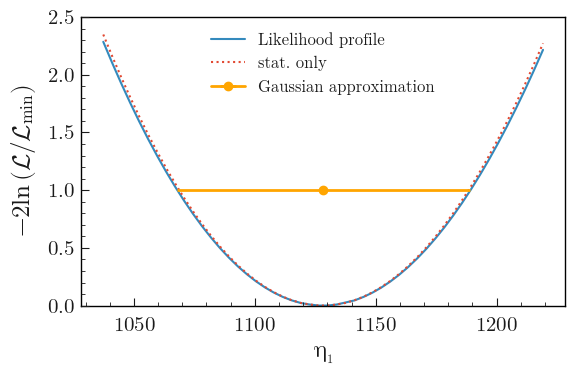

In [38]:
plot_likelihood_scan(fit_result, *likelihood_scan(fit_result, 0), 0, figname="profile-limitedmc-ipar0")
plot_likelihood_scan(fit_result, *likelihood_scan(fit_result, 1), 1, figname="profile-limitedmc-ipar1")

We can check on which nuisance parameters the fit tried to pull

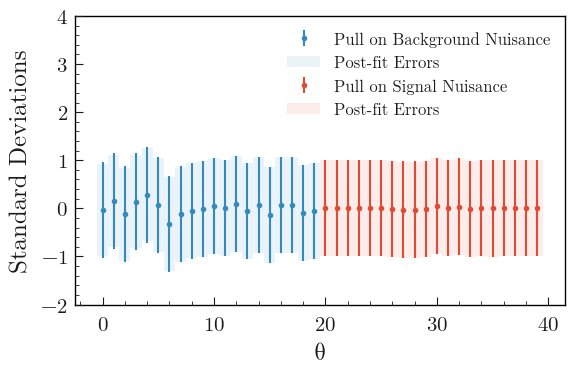

In [39]:
def plot_pulls_on_bins(fit_result, figname=None):

    plt.errorbar(range(0, bins), fit_result.x[2:bins+2], yerr=1,
                ls='', marker='.', label="Pull on Background Nuisance"
                )
    plt.bar(range(0, bins), height=2*np.diagonal(fit_result.covariance[2:bins+2, 2:bins+2])**0.5,
            bottom=fit_result.x[2:bins+2]-np.diagonal(fit_result.covariance[2:bins+2, 2:bins+2])**0.5,
            width=1, alpha=0.1, label="Post-fit Errors"
           )
    plt.errorbar(range(bins, 2*bins), fit_result.x[bins+2:2*bins+2], yerr=1,
                ls='', marker='.', label='Pull on Signal Nuisance'
                )
    plt.bar(range(bins, 2*bins), height=2*np.diagonal(fit_result.covariance[bins+2:2*bins+2, bins+2:2*bins+2])**0.5,
            bottom=fit_result.x[bins+2:2*bins+2]-np.diagonal(fit_result.covariance[bins+2:2*bins+2, bins+2:2*bins+2])**0.5,
            width=1, alpha=0.1, label="Post-fit Errors"
           )

    plt.legend()
    plt.ylim(-2, 4)
    plt.xlabel(r"$\theta$")
    plt.ylabel("Standard Deviations")
    plt.tight_layout();
    if figname is not None:
        plt.savefig(os.path.join(DIRNAME, figname + ".png"), transparent=True, bbox_inches='tight')
        plt.savefig(os.path.join(DIRNAME, figname + ".pdf"))
    plt.show()        
    plt.close()
    
plot_pulls_on_bins(fit_result, figname="nuisance-limitedmc")

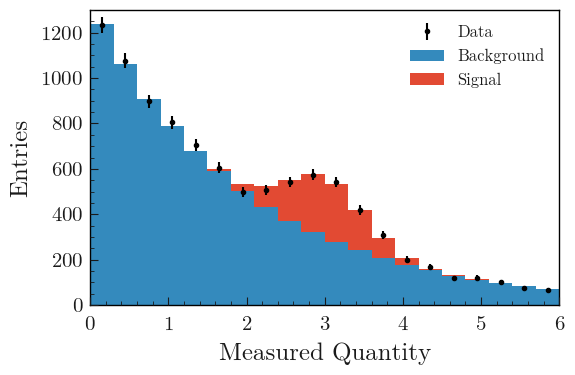

In [40]:
plot_template(*sample, fit_result, debug=False, figname="template-limitedmc")

In [41]:
# toy_fit_results = generate_toy(50)

In [42]:
# plot_toy_fit_results(toy_fit_results, 0, nu_bkg_expected, "toy-limitedmc-ipar0")
# plot_toy_fit_results(toy_fit_results, 1, nu_sig_expected, "toy-limitedmc-ipar1")

### Let's include model systematics

Our background model can be written as $\mathcal{E}(\lambda=(2\pm 0.2))$. We have our central value $\lambda=2$ and an assoicated covariance matrix (in our case 1D) $\mathcal{C} = (0.04)$.

To incorporate this in our fit, we now determine how this systematic uncertainty can be built into our template.

There are sometimes easier ways, e.g. via reweighting, but now we do the following:
* Diagonalize the covariance matrix.
* Vary each eigenvalue by +- 1 sigma.
* For each variation, rotate it back and generate a new template.
In our case this is easy, because it is only 1D! So:

In [43]:
distributions_up = [
        { "type": np.random.exponential, "kwargs": { "scale": 2.0 + 0.2 }},
        { "type": np.random.normal,  "kwargs": { "loc": 3.5, "scale": 0.5 }},
    ]

template_bkg_plus, _ = np.histogram(
    generate_distribution(n_bkg, distributions_up, 0),
    bins=bins, range=x_range, 
    weights=np.ones(len(bkg_mc))/100)

In [44]:
distributions_down = [
        { "type": np.random.exponential, "kwargs": { "scale": 2.0 - 0.2 }},
        { "type": np.random.normal,  "kwargs": { "loc": 3.5, "scale": 0.5 }},
    ]

template_bkg_minus, _ = np.histogram(
    generate_distribution(n_bkg, distributions_down, 0),
    bins=bins, range=x_range, 
    weights=np.ones(len(bkg_mc))/100)

We now have the nominal distribution, plus two distributions which are varied by the eigenvalue of the covariance matrix of the nuisance parameter.
We know calculate how this variation impacts the expectation in each bin.
We symmetrize the error here so we can use it as a covariance

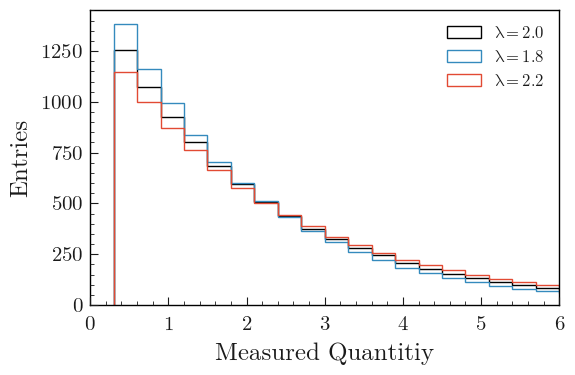

In [45]:
plt.hist(
    template_bkg_boundaries[:-1] + (template_bkg_boundaries[1] - template_bkg_boundaries[0]),
    bins= template_bkg_boundaries + (template_bkg_boundaries[1] - template_bkg_boundaries[0]),
    weights=template_bkg,    label=r'$\lambda = 2.0$', histtype='step', color='black'
)

plt.hist(
    template_bkg_boundaries[:-1] + (template_bkg_boundaries[1] - template_bkg_boundaries[0]),
    bins= template_bkg_boundaries + (template_bkg_boundaries[1] - template_bkg_boundaries[0]),
    weights=template_bkg_minus,    label=r'$\lambda = 1.8$', histtype='step'
)

plt.hist(
    template_bkg_boundaries[:-1] + (template_bkg_boundaries[1] - template_bkg_boundaries[0]),
    bins= template_bkg_boundaries + (template_bkg_boundaries[1] - template_bkg_boundaries[0]),
    weights=template_bkg_plus,    label=r'$\lambda = 2.2$', histtype='step'
)

plt.legend()
plt.xlabel("Measured Quantitiy")
plt.ylabel("Entries")
# plt.yscale('log')
plt.xlim(0,6)
plt.tight_layout();
plt.savefig(os.path.join(DIRNAME, "template-model-uncertainty.pdf"))
plt.savefig(os.path.join(DIRNAME, "template-model-uncertainty.png"), transparent=True, bbox_inches='tight')
plt.show()
plt.close()

In [46]:
def get_model_uncertainty(nominal, plus, minus):
    down_variation = minus - nominal
    up_variation = plus - nominal
    model_uncertainty_per_bin = (np.sign(down_variation) * (abs(down_variation) + abs(up_variation))) / 2
    return model_uncertainty_per_bin

In [47]:
get_model_uncertainty(template_bkg, template_bkg_plus, template_bkg_minus)

array([118.25 ,  81.34 ,  60.98 ,  35.525,  20.3  ,  11.52 ,   4.09 ,
        -4.785, -10.185, -13.175, -16.765, -17.09 , -19.125, -18.27 ,
       -18.81 , -16.94 , -17.185, -16.34 , -14.435, -14.455])

The theory error is 100% correlated, so we calculate the covariance as the outer product $\sigma \otimes \sigma$:

In [48]:
model_uncertainty_per_bin = get_model_uncertainty(template_bkg, template_bkg_plus, template_bkg_minus)

In [49]:
bkg_model_covariance = np.outer(model_uncertainty_per_bin, model_uncertainty_per_bin)

Now we simply add up the uncertainties and covariance matrices, calculate the relative errors and correlation matrices anew

In [50]:
template_bkg_relative_errors, inv_bkg_correlation = get_relative_error_and_inv_correlation(
    template_bkg, bkg_stat_covariance + bkg_model_covariance)
template_sig_relative_errors, inv_sig_correlation = get_relative_error_and_inv_correlation(
    template_sig, sig_stat_covariance)

def L(x, *pars):
    return likelihood(x, 
                      template_bkg_relative_errors, template_sig_relative_errors, 
                      inv_bkg_correlation, inv_sig_correlation,
                      *pars)

In [51]:
fit_result = scipy.optimize.minimize(
    lambda x: L(sample, *x),
    x0=(nu_bkg_expected, nu_sig_expected, *np.zeros(40)),
    method="SLSQP"
)

In [52]:
hesse = numdifftools.Hessian(
    lambda x: L(sample, *x))(fit_result.x)

fit_result.covariance =  np.linalg.inv(hesse / 2)

In [53]:
print_fit_result(fit_result)


    nu(bkg) = 8423.50+/-108.09
    nu(sig) = 1139.87+/-66.33
    


In [54]:
fit_result_model_sys = deepcopy(fit_result)

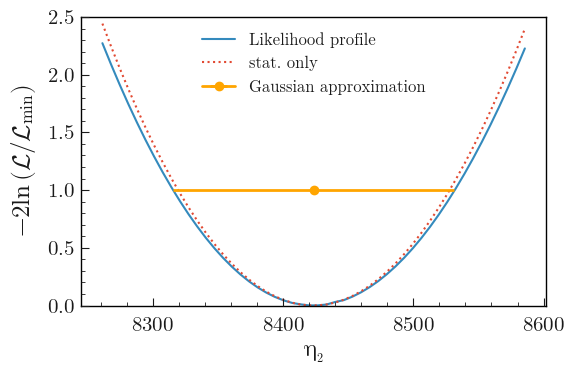

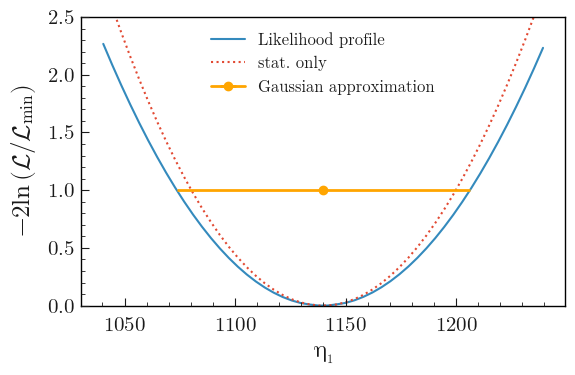

In [55]:
plot_likelihood_scan(fit_result, *likelihood_scan(fit_result, 0), 0, figname="profile-modeluncertainty-ipar0")
plot_likelihood_scan(fit_result, *likelihood_scan(fit_result, 1), 1, figname="profile-modeluncertainty-ipar1")

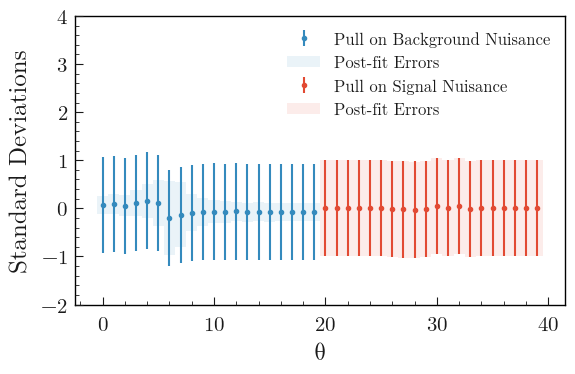

In [56]:
plot_pulls_on_bins(fit_result, figname="nuisance-modeluncertainty")

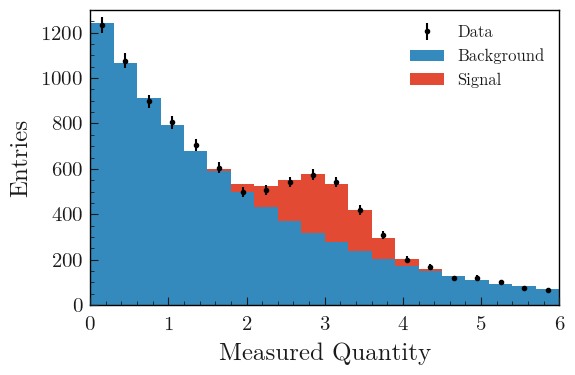

In [57]:
plot_template(*sample, fit_result, debug=False, figname="template-modeluncertainty")

In [58]:
# toy_fit_results = generate_toy(50)

In [59]:
# plot_toy_fit_results(toy_fit_results, 0, nu_bkg_expected, "toy-modeluncertainty-ipar0")
# plot_toy_fit_results(toy_fit_results, 1, nu_sig_expected, "toy-modeluncertainty-ipar1")

# Modify the likelihood 

Next we want to incorporate the uncertainty of the tracking to our signal template. This works a bit differently, as it is a multiplicative uncertainty. To include this in the likelihood, we introduce a single nuisance parameter (assuming the tracking uncertainty is constant across our measured quanitity):

$\eta_k \rightarrow \eta_k (1 + \epsilon_s \theta_{ks}$)

This introduces a single new nuisance parameter $\theta_{ks}$ which allows to pull on the uncertainty $\epsilon_s$ for template $k$.

Let us assume we have a systematic error of 3\% on the tracking efficiency, $\epsilon_s = 0.03$.

In [60]:
def likelihood(x, 
               bkg_errors, sig_errors,
               inv_bkg_correlation, inv_sig_correlation, 
               multiplicative_uncertainties,
               *pars):
    data, bkg, sig = x

    nBins = 20
    nParamaterOfInterest = 2
    nParameterOfNuisance = 2 * nBins
    par_interest = np.array(pars[:nParamaterOfInterest])
    par_nuisance = np.array(pars[nParamaterOfInterest:nParamaterOfInterest+nParameterOfNuisance])
    par_nuisance_mult = np.array(pars[nParamaterOfInterest+nParameterOfNuisance:])
    
    for eps, th in zip(multiplicative_uncertainties, par_nuisance_mult):
        par_interest[1] = par_interest[1] * (1 + eps * th)
    
    use_nuisance = True
    if len(par_nuisance) == 0:
        par_nuisance = np.zeros(nParameterOfNuisance)
        use_nuisance = False
        
    par_nuisance_bkg = par_nuisance[:nBins]
    par_nuisance_sig = par_nuisance[nBins:]
    
    if use_nuisance:
        fractiong_bkg = bkg * (1 + par_nuisance_bkg * bkg_errors) / sum(bkg * (1 + par_nuisance_bkg * bkg_errors))
        fractions_sig = sig * (1 + par_nuisance_sig * sig_errors) / sum(sig * (1 + par_nuisance_sig * sig_errors))
    else:
        fractiong_bkg = bkg / sum(bkg)
        fractions_sig = sig / sum(sig)

    eta_k = [fractiong_bkg, fractions_sig]
    
    nu_0_per_bin = par_interest[0] * eta_k[0]
    nu_1_per_bin = par_interest[1] * eta_k[1]
    nu_per_bin = [nu_0_per_bin, nu_1_per_bin]
    
    if use_nuisance:
        return -2 * sum(np.log(scipy.stats.poisson.pmf(data, sum(nu_per_bin)))) \
                + par_nuisance_bkg @ inv_bkg_correlation @ par_nuisance_bkg \
                + par_nuisance_sig @ inv_sig_correlation @ par_nuisance_sig \
                + sum(par_nuisance_mult**2)
    else:
        return -2 * sum(np.log(scipy.stats.poisson.pmf(data, sum(nu_per_bin))))

In [61]:
template_bkg_relative_errors, inv_bkg_correlation = get_relative_error_and_inv_correlation(
    template_bkg, bkg_stat_covariance + bkg_model_covariance)
template_sig_relative_errors, inv_sig_correlation = get_relative_error_and_inv_correlation(
    template_sig, sig_stat_covariance)
multiplicative_errors = np.array([0.03,])

def L(x, *pars):
    return likelihood(x, 
                      template_bkg_relative_errors, template_sig_relative_errors, 
                      inv_bkg_correlation, inv_sig_correlation,
                      multiplicative_errors,
                      *pars)

In [62]:
fit_result = scipy.optimize.minimize(
    lambda x: L(sample, *x),
    x0=(nu_bkg_expected, nu_sig_expected, *np.zeros(40), 0),
    method="SLSQP"
)

In [63]:
hesse = numdifftools.Hessian(
    lambda x: L(sample, *x))(fit_result.x)

fit_result.covariance =  np.linalg.inv(hesse / 2)

In [64]:
print_fit_result(fit_result)


    nu(bkg) = 8423.08+/-108.09
    nu(sig) = 1139.68+/-74.62
    


In [65]:
print("""
    theta(tracking) = {:.2f}
    """.format(ufloat(fit_result.x[-1], fit_result.covariance[-1, -1] ** 0.5))
     )


    theta(tracking) = 0.00+/-1.00
    


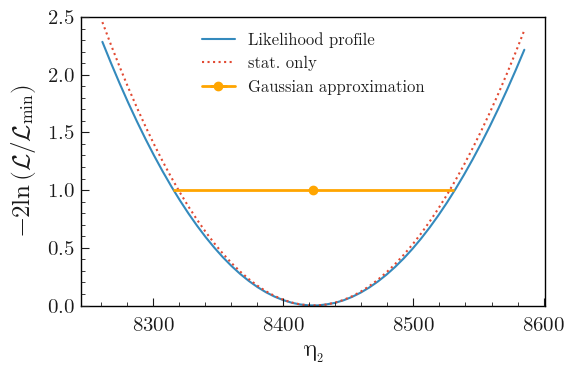

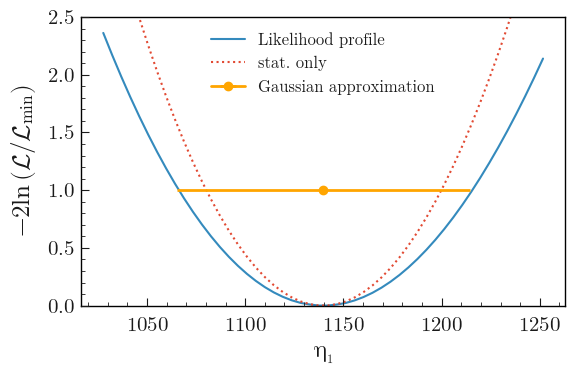

In [66]:
plot_likelihood_scan(fit_result, *likelihood_scan(fit_result, 0), 0, figname="profile-multiplicative-ipar0")
plot_likelihood_scan(fit_result, *likelihood_scan(fit_result, 1), 1, figname="profile-multiplicative-ipar1")

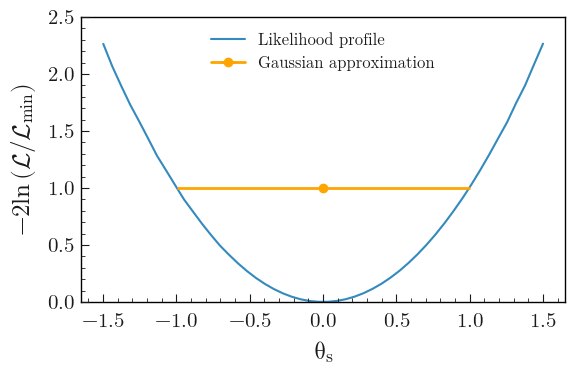

In [67]:
plot_likelihood_scan(fit_result, *likelihood_scan(fit_result, 42), 42, figname="profile-multiplicative-iparTracking")

In [68]:
fit_result.x[-1], fit_result.covariance[-1, -1]**0.5

(0.0007904315980792872, 0.9999779405997185)

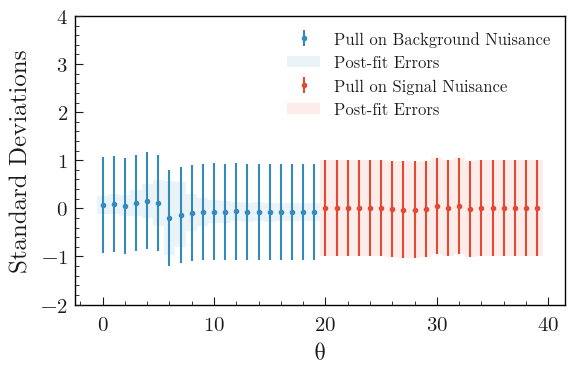

In [69]:
plot_pulls_on_bins(fit_result, "nuisance-multiplicative")

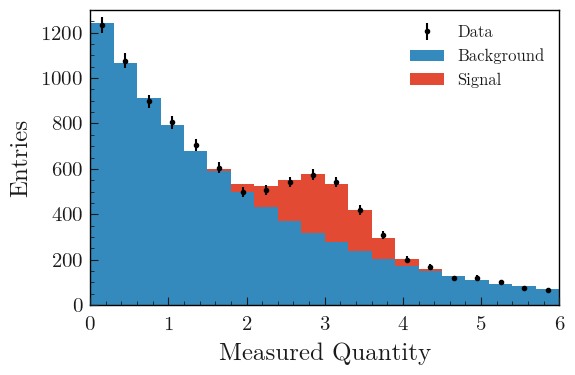

In [70]:
plot_template(*sample, fit_result, debug=False, figname="template-multiplicative")

In [71]:
# toy_fit_results = generate_toy(50)

In [72]:
# plot_toy_fit_results(toy_fit_results, 0, nu_bkg_expected, figname="toy-multiplicative-ipar0")
# plot_toy_fit_results(toy_fit_results, 1, nu_sig_expected, figname="toy-multiplicative-ipar1")